## **InformationRetrievalEvaluator** from sentence_transformers
This provides a more comprehensive suite of metrics, but we can only run it against the sentencetransformers compatible models (open source and our finetuned model, not the OpenAI embedding model).

In [36]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers import SentenceTransformer
from pathlib import Path
import pandas as pd
from utils.utils_embedding import load_qa_dataset

In [37]:
dataset_name = "QA/gpt-35-turbo_dataset.json"
baseline_model_id = "paraphrase-multilingual-MiniLM-L12-v2"
finetuned_model_id = "finetuned-sentence-transformers/finetuned-paraphrase-multilingual-MiniLM-L12-v2"

In [38]:
dataset = load_qa_dataset(dataset_name)

2025-07-22 16:48:40.184 | INFO     | utils.utils_embedding:load_qa_dataset:16 - Loading dataset from QA/gpt-35-turbo_dataset.json


In [39]:
def fast_retriever_evaluator_sentence_transformer(dataset, model_id, name):
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs
    evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs, name=name)
    model = SentenceTransformer(model_id)
    output_path = "results/"
    Path(output_path).mkdir(exist_ok=True, parents=True)
    return evaluator(model, output_path=output_path)

In [40]:
# Baseline embedding model
dict_results = fast_retriever_evaluator_sentence_transformer(dataset, model_id=baseline_model_id, name="paraphrase-multilingual-MiniLM-L12-v2")
# Finetuned embedding model
dict_results = fast_retriever_evaluator_sentence_transformer(dataset, model_id=finetuned_model_id, name="finetuned-paraphrase-multilingual-MiniLM-L12-v2")

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Information Retrieval Evaluation of the model on the paraphrase-multilingual-MiniLM-L12-v2 dataset:
Information Retrieval Evaluation of the model on the paraphrase-multilingual-MiniLM-L12-v2 dataset:
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Queries: 260
Queries: 260
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Corpus: 260

Corpus: 260

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Score-Function: cosine
Score-Function: cosine
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@1: 45.38%
Accuracy@1: 45.38%
INFO:sentence_transfor

In [41]:
df_finetuned = pd.read_csv("results/Information-Retrieval_evaluation_finetuned-paraphrase-multilingual-MiniLM-L12-v2_results.csv")
df_no_finetuned = pd.read_csv("results/Information-Retrieval_evaluation_paraphrase-multilingual-MiniLM-L12-v2_results.csv")

# drop columns epoch and steps for plotting
df_finetuned = df_finetuned.drop(columns=["epoch", "steps"])
df_no_finetuned = df_no_finetuned.drop(columns=["epoch", "steps"])

In [42]:
df_finetuned

,cosine-Accuracy@1,cosine-Accuracy@3,cosine-Accuracy@5,cosine-Accuracy@10,cosine-Precision@1,cosine-Recall@1,cosine-Precision@3,cosine-Recall@3,cosine-Precision@5,cosine-Recall@5,cosine-Precision@10,cosine-Recall@10,cosine-MRR@10,cosine-NDCG@10,cosine-MAP@100
0,0.611538,0.769231,0.823077,0.85,0.611538,0.611538,0.25641,0.769231,0.164615,0.823077,0.085,0.85,0.697718,0.735158,0.702163


In [43]:
df_no_finetuned

,cosine-Accuracy@1,cosine-Accuracy@3,cosine-Accuracy@5,cosine-Accuracy@10,cosine-Precision@1,cosine-Recall@1,cosine-Precision@3,cosine-Recall@3,cosine-Precision@5,cosine-Recall@5,cosine-Precision@10,cosine-Recall@10,cosine-MRR@10,cosine-NDCG@10,cosine-MAP@100
0,0.453846,0.607692,0.653846,0.707692,0.453846,0.453846,0.202564,0.607692,0.130769,0.653846,0.070769,0.707692,0.537966,0.57911,0.544551


In [45]:
df_improvement_perc = (df_finetuned - df_no_finetuned)/ df_no_finetuned * 100
df_improvement_perc.to_csv("results/Information-Retrieval_evaluation_improvement_perc.csv")
df_improvement_perc

,cosine-Accuracy@1,cosine-Accuracy@3,cosine-Accuracy@5,cosine-Accuracy@10,cosine-Precision@1,cosine-Recall@1,cosine-Precision@3,cosine-Recall@3,cosine-Precision@5,cosine-Recall@5,cosine-Precision@10,cosine-Recall@10,cosine-MRR@10,cosine-NDCG@10,cosine-MAP@100
0,34.745763,26.582278,25.882353,20.108696,34.745763,34.745763,26.582278,26.582278,25.882353,25.882353,20.108696,20.108696,29.695723,26.946271,28.943414


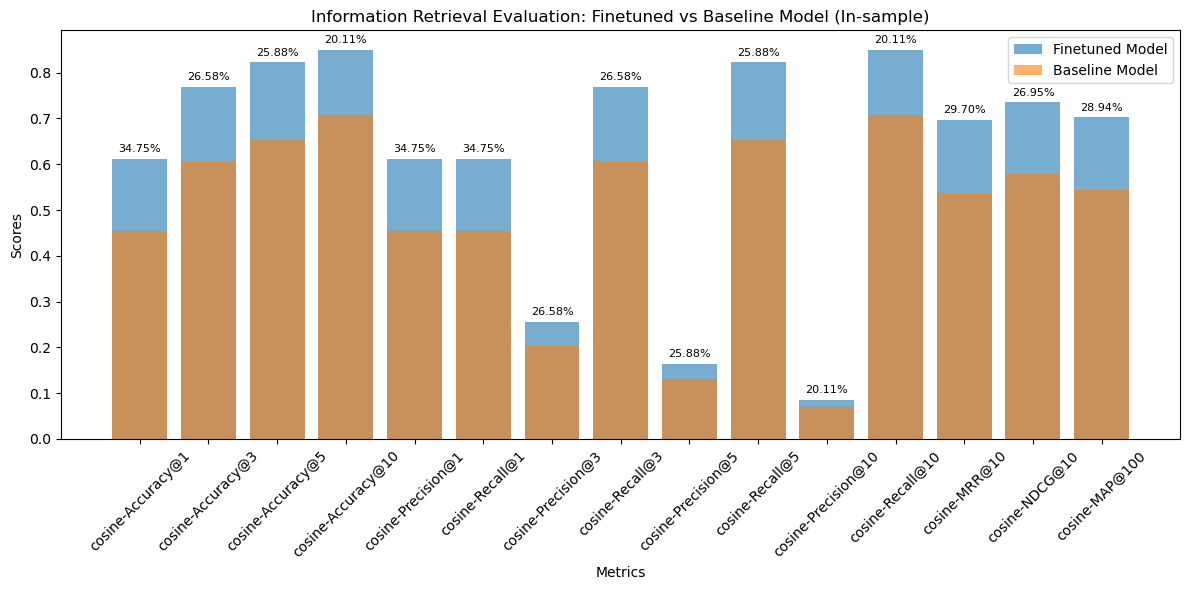

In [48]:
# plot bar charts for finetuned and no finetuned models
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_finetuned.columns, df_finetuned.iloc[0], label='Finetuned Model', alpha=0.6)
plt.bar(df_no_finetuned.columns, df_no_finetuned.iloc[0], label='Baseline Model', alpha=0.6)
plt.xticks(rotation=45)
plt.title('Information Retrieval Evaluation: Finetuned vs Baseline Model (In-sample)')
for i, v in enumerate(df_improvement_perc.iloc[0]):
    plt.text(i, df_finetuned.iloc[0, i] + 0.01, f"{v:.2f}%", ha='center', va='bottom', fontsize=8)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

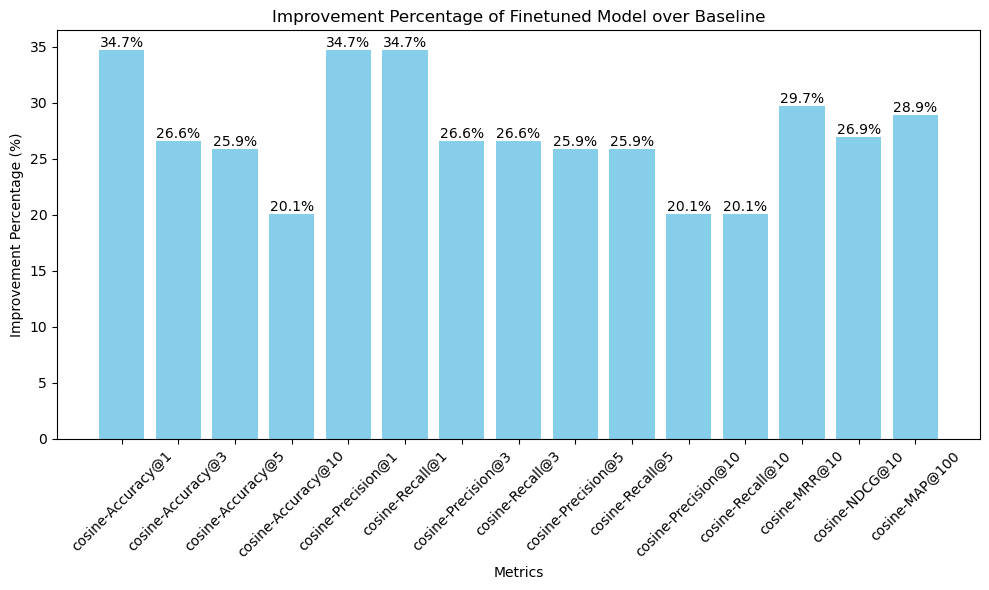

In [ ]:
# plot histogram with percentage at the top of each bar
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.bar(df_improvement_perc.columns, df_improvement_perc.iloc[0], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Improvement Percentage (%)')
plt.title('Improvement Percentage of Finetuned Model over Baseline (In-sample)')
for i, v in enumerate(df_improvement_perc.iloc[0]):
    plt.text(i, v, f"{v:.1f}%", ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
